In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon
from geopy import distance
import requests
import json
import osm2geojson


## Определим города для каждого салона

прочитаем Train и Test

In [2]:
train = pd.read_csv('data/mf_geo_train.csv')
test = pd.read_csv('data/mf_geo_test.csv')

Функция для получения geoDataFrame по запросу в overpass api. 
Для перевода обычного json, возвращаемого overpass, в geojson, содержащий shape, используем библиотеку osm2geojson


In [3]:
def get_GeoPandas(query, column_name):
    overpass_url = "http://overpass-api.de/api/interpreter"
    response = requests.get(overpass_url, 
                        params={'data': query})
    data = response.json()
    data_geo = osm2geojson.json2shapes(data)
    
    Multi_Polygons = []
    for i in data_geo:
        if type(i['shape']) is MultiPolygon:
            Multi_Polygons.append(i)
            
    Column = []
    Shape = []
    for MP in Multi_Polygons:
        Column.append(MP['properties']['tags']['name'])
        Shape.append(MP['shape'])
    gDF = gpd.GeoDataFrame({column_name : Column, 'geometry':Shape},crs={'init': 'epsg:4326'})
    
    return gDF

Функция для расчета расстояния от каждого объекта DF до ближайшей точки из Points  
Для нахождения расстояния используем distance.great_circle.  
Данная функция понадобиться для генерации признаков.

In [4]:
def min_dist(df, Points):
    dist_list = []
    for i in range(df.shape[0]):
        min_dist = 1000000
        y_MF = df.iloc[i].geometry.y
        x_MF = df.iloc[i].geometry.x
        MF_point = (y_MF, x_MF)
        # Для объекта из DF находим расстояние до каждой из точек и сохраняем минимальное
        for p in Points:
            y_point = p.y
            x_point = p.x
            p_point = (y_point, x_point)
            distance_point_MF = distance.great_circle(MF_point, p_point).km
            if distance_point_MF < min_dist:
                min_dist = distance_point_MF
        dist_list.append(min_dist)
    return dist_list

Функция для поучения буферной зоны вокруг точки с использованием азимутальных равнопромежуточных проекций

In [5]:
from functools import partial
import pyproj
from shapely.ops import transform

proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')

def geodesic_point_buffer(lon, lat, km):
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lon=lon, lat=lat)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000) 
    return transform(project, buf) # Если точка, попавшая в буферную зону, только одна, возвращает ее координату 
                                   # Если точек несколько, возвращает класс MultiPoint, который содержит попавшие точки

Подсчет кол-ва точек из Points, попавших в буферную зону в км для каждого объекта из df

In [6]:
def buf_points_counts(df, Points, km):
    buf_list = []
    for i in range(df.shape[0]):
        # строим буферную зону вокруг каждого объекта из DF 
        inter = geodesic_point_buffer(df.iloc[i].lon,df.iloc[i].lat,km).intersection(Points)
        if inter.is_empty :
            buf_list.append(0) # если в буф.зоне объектов нет, возвращаем ноль
        elif type(inter) == Point:
            buf_list.append(1) # если только одна точка, возвращаем 1
        else:
            buf_list.append(len(inter)) # если тип - MultiPoint, возвращаем длину данного класса
                                        #(кол-во точек)
            
    return buf_list

Получение geojson с shapes из запроса в overpass api

In [7]:
overpass_url = "http://overpass-api.de/api/interpreter"

def response_to_shapejson(query):
    response = requests.get(overpass_url, 
                        params={'data': query})
    data = response.json()
    data_geo = osm2geojson.json2shapes(data)
    return data_geo

Скачаем из osm границы городов.  
Для Казани и Нижнего Новгорода скачаем отдельно, так как запрос будет немного отличаться.  
Также скачаем административные границы России.


(При одновременном запуске всех ячеек json иногда выдаёт ошибка. Если запускать все ячейки с requests по отдельности то ошибки не появляются)

In [9]:
overpass_query = """
[out:json];
(
  relation["place"~"city"]["addr:country"~"RU"];
);
out geom;
out center;
"""

Citys_gdf = get_GeoPandas(overpass_query, 'City')

overpass_query = """
[out:json];
(
    rel["ISO3166-2"~"^RU"]
   [admin_level=4]
   [type=boundary]
   [boundary=administrative];
);
out geom;
"""

Admin_gdf = get_GeoPandas(overpass_query, 'Admin')

overpass_query = """
[out:json];
(
  relation["name"="Нижний Новгород"]["place"="city"];
);
out geom;
"""
NN_gdf = get_GeoPandas(overpass_query, 'City')

overpass_query = """
[out:json];
(
  relation["name"="Казань"]["place"="city"];
);
out geom;
"""
Kazan_gdf = get_GeoPandas(overpass_query, 'City')

Citys_gdf = pd.concat([pd.concat([Citys_gdf, NN_gdf]), Kazan_gdf])
Citys_gdf.reset_index(inplace = True)

Failed to convert relation to shape {'id': 1750338,
 'tags': {'addr:country': 'RU',
          'admin_level': '8',
          'int_name': 'Nyagan',
          'name': 'Нягань',
          'old_name': 'Нях',
          'place': 'city',
          'place_name': 'Нягань'},
 'type': 'relation'}
Failed to convert relation to shape {'id': 1750338,
 'tags': {'addr:country': 'RU',
          'admin_level': '8',
          'int_name': 'Nyagan',
          'name': 'Нягань',
          'old_name': 'Нях',
          'place': 'city',
          'place_name': 'Нягань'},
 'type': 'relation'}


Попробуем построить карту России

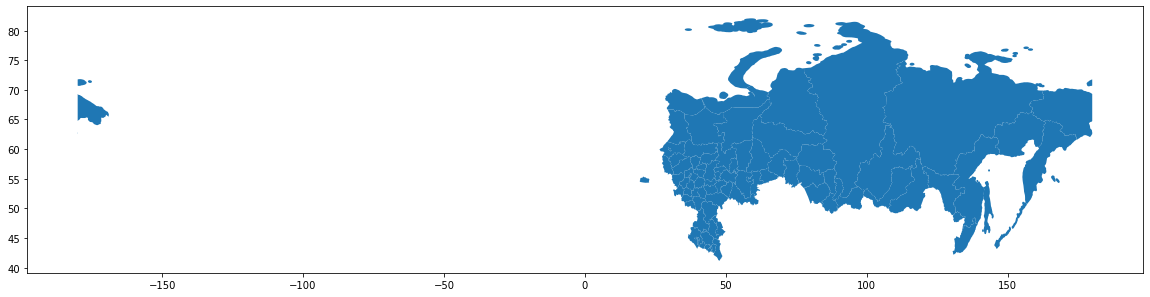

In [10]:
Admin_gdf.plot(figsize = (20,20))

Посмотрим на границы Москвы, полученные через запрос type = City и через запрос [admin_level=4][type=boundary].  

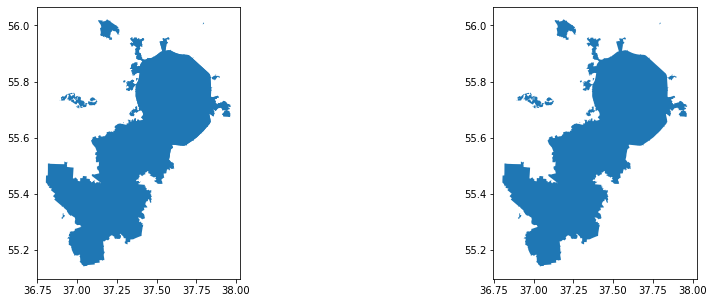

In [11]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
Citys_gdf[Citys_gdf.City == 'Москва'].plot(ax = ax[0])
Admin_gdf[Admin_gdf.Admin == 'Москва'].plot(ax = ax[1])

Видим, что при запросе type = City, мы не учитываем Новую Москву.  
Также посмотрим на Санкт-Петербург.

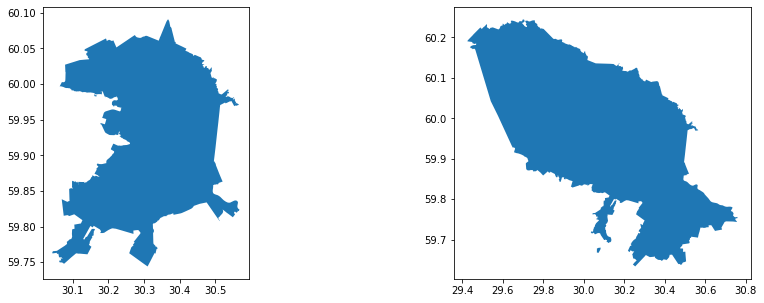

In [12]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
Citys_gdf[Citys_gdf.City == 'Санкт-Петербург'].plot(ax = ax[0])
Admin_gdf[Admin_gdf.Admin == 'Санкт-Петербург'].plot(ax = ax[1])

Видим аналогичную ситуацию.  
Заменим в Citys_gdf границы Москву и Санкт-Петербурга на их границы из Admin_gdf. Также удалим из Citys_gdf маленькие города(Зеленоград, Пушкнин, Колпино), которые теперь входят в границу Москвы и Санкт-Петербурга.

In [13]:
Citys_gdf.drop(Citys_gdf[Citys_gdf.City == 'Москва'].index.tolist(),
              axis = 0,
              inplace = True)
Citys_gdf = Citys_gdf.append({'geometry':Admin_gdf[Admin_gdf.Admin == 'Москва'].iloc[0].geometry,
                  'City':'Москва'},ignore_index=True)


Citys_gdf.drop(Citys_gdf[Citys_gdf.City == 'Санкт-Петербург'].index.tolist(),
              axis = 0,
              inplace = True)
Citys_gdf = Citys_gdf.append({'geometry':Admin_gdf[Admin_gdf.Admin == 'Санкт-Петербург'].iloc[0].geometry,
                  'City':'Санкт-Петербург'}, ignore_index=True)

Citys_gdf.drop(Citys_gdf[Citys_gdf.City == 'Пушкин'].index.tolist(),
              axis = 0,
              inplace = True)

Citys_gdf.drop(Citys_gdf[Citys_gdf.City == 'Зеленоград'].index.tolist(),
              axis = 0,
              inplace = True)

Citys_gdf.drop(Citys_gdf[Citys_gdf.City == 'Колпино'].index.tolist(),
              axis = 0,
              inplace = True)

Сделаем из train и test GeoDataFrame

In [14]:
train_geom = []
for i in range(train.shape[0]):
    train_geom.append(Point((train.iloc[i].lon, train.iloc[i].lat)))
train['geometry'] = train_geom #  GeoDataFrame должен содержать поле geometry с геометрией объекта
gpd_train = gpd.GeoDataFrame(train)

test_geom = []
for i in range(test.shape[0]):
    test_geom.append(Point((test.iloc[i].lon, test.iloc[i].lat)))
test['geometry'] = test_geom
gpd_test = gpd.GeoDataFrame(test)

С помощью sjoin найдем в каких городах находятся салоны

In [15]:
Train = gpd.sjoin(gpd_train, Citys_gdf, op = 'within') 
Train

,point_id,lon,lat,target,geometry,index_right,index,City
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),132,NaN,Москва
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),132,NaN,Москва
3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),132,NaN,Москва
4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),132,NaN,Москва
7,CO76tdVs,37.444304,55.850511,0.213704,POINT (37.44430 55.85051),132,NaN,Москва
...,...,...,...,...,...,...,...,...
384,mZTEZ4bf,50.158969,53.197251,-0.261717,POINT (50.15897 53.19725),88,91.0,Самара
387,2SKYY79M,50.246331,53.212183,3.239111,POINT (50.24633 53.21218),88,91.0,Самара
389,ZfB8GmX1,50.188602,53.191244,0.170484,POINT (50.18860 53.19124),88,91.0,Самара
404,fI0HvX5p,50.225666,53.259281,0.300144,POINT (50.22567 53.25928),88,91.0,Самара


Посмотрим, сколько салонов из train в каждом городе

In [16]:
Train.City.value_counts()

Москва             161
Санкт-Петербург     83
Самара              27
Новосибирск         26
Казань              25
Екатеринбург        22
Ростов-на-Дону      21
Нижний Новгород     21
Красноярск          20
Уфа                 19
Name: City, dtype: int64

In [17]:
Test = gpd.sjoin(gpd_test, Citys_gdf, op = 'within')
Test

,point_id,lon,lat,target,geometry,index_right,index,City
0,F4lXR1cG,37.681242,55.748040,0.0091,POINT (37.68124 55.74804),132,NaN,Москва
2,kLuAAN3s,37.598614,55.781357,0.0091,POINT (37.59861 55.78136),132,NaN,Москва
3,OxQHvaNu,37.794051,55.717468,0.0091,POINT (37.79405 55.71747),132,NaN,Москва
5,7x7uZwPc,37.617141,55.795433,0.0091,POINT (37.61714 55.79543),132,NaN,Москва
7,OMCMewkC,37.798028,55.810580,0.0091,POINT (37.79803 55.81058),132,NaN,Москва
...,...,...,...,...,...,...,...,...
39,WRf9qCgC,93.015521,55.988184,0.0091,POINT (93.01552 55.98818),24,26.0,Красноярск
72,2VNvJAyN,92.932816,56.002145,0.0091,POINT (92.93282 56.00214),24,26.0,Красноярск
95,9um9WSSk,92.950129,55.995629,0.0091,POINT (92.95013 55.99563),24,26.0,Красноярск
103,4nmfqUw0,92.928927,56.116262,0.0091,POINT (92.92893 56.11626),24,26.0,Красноярск


In [18]:
#удалим неинформативные поля, оставшиеся после sjoin
Train.drop(['index_right','index'],axis = 1, inplace=True)
Test.drop(['index_right','index'],axis=1, inplace=True)

## Генерируем признаки

#### Посчитаем среднее значение таргета в каждом городе и добавим как признак

In [19]:
Train['avr_tar_City'] = 0
dict_avr = {}
for City in Train.City.unique():
    avr = Train[Train.City == City].target.mean()
    dict_avr[City] = avr
    Train.loc[Train.City == City, 'avr_tar_City'] = avr

In [20]:
Test['avr_tar_City'] = 0
for City in Test.City.unique():
    Test.loc[Test.City == City, 'avr_tar_City'] = dict_avr[City]

In [21]:
Train

,point_id,lon,lat,target,geometry,City,avr_tar_City
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),Москва,0.252092
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),Москва,0.252092
3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),Москва,0.252092
4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),Москва,0.252092
7,CO76tdVs,37.444304,55.850511,0.213704,POINT (37.44430 55.85051),Москва,0.252092
...,...,...,...,...,...,...,...
384,mZTEZ4bf,50.158969,53.197251,-0.261717,POINT (50.15897 53.19725),Самара,0.953248
387,2SKYY79M,50.246331,53.212183,3.239111,POINT (50.24633 53.21218),Самара,0.953248
389,ZfB8GmX1,50.188602,53.191244,0.170484,POINT (50.18860 53.19124),Самара,0.953248
404,fI0HvX5p,50.225666,53.259281,0.300144,POINT (50.22567 53.25928),Самара,0.953248


#### Найдем вокзалы (междугородние) для каждого города

Предположение: фичерфоны покупают по приезду в новый регион для второй симки.  
Так как мы хотим получить именно междугородние вокзалы, скачаем точки для каждого города отдельно, так как в каждом городе разметка osm немного отличается.

In [22]:
railway = []
# Самара
query = """
[out:json];
    node
    ["railway"="station"]
    ["name"~"Самара"]
    ["station"!="subway"](53.091673, 49.746151,53.550744,50.390389);
out geom;
"""
data_geo = response_to_shapejson(query)
railway += [i['shape'] for i in data_geo]

In [23]:
# Питер
query = """
[out:json];
    node
        ["railway"="station"]
        ["name"~"Санкт-Петербург|Ладожская"]
        ["name"!~"Товарный"]
        ["station"!="subway"](59.6914,29.5289,60.203,30.8665);
out geom;
"""
data_geo = response_to_shapejson(query)
railway += [i['shape'] for i in data_geo]

In [24]:
# Москва
query = """
[out:json];
node
  ["railway"="station"]
  ["name"~"Пассажирская|Рижская|Савёловская"]
  ["station"!="subway"]
  (55.2909,36.8596,56.1602,38.5734);
out geom;
"""
data_geo = response_to_shapejson(query)
railway += [i['shape'] for i in data_geo]

In [25]:
# Новосибирск
query = """
[out:json];
    node
    ["railway"="station"]
    ["name"~"Новосибирск"]
    ["station"!="subway"](54.942784,82.659964,55.141073,83.126883);
out geom;
"""
data_geo = response_to_shapejson(query)
railway += [i['shape'] for i in data_geo]

In [26]:
# Казань
query = """ 
[out:json];
  node
    ["railway"="station"]
    ["name"~"Пассажирская"]
    ["station"!="subway"](55.603478,48.820585,55.938219,49.381247);
out geom;
"""
data_geo = response_to_shapejson(query)
railway += [i['shape'] for i in data_geo]

In [27]:
# Екатеринбург
query = """
[out:json];
  node
    ["railway"="station"]
    ["name"~"Пассажирск"]
    ["station"!="subway"](56.706305,60.261472,57.031555,60.822134);
out geom;
"""
data_geo = response_to_shapejson(query)
railway += [i['shape'] for i in data_geo]

In [28]:
# Нижний Новгород
query = """
[out:json];
  node
    ["railway"="station"]
    ["name"~"Нижний Новгород"]
    ["station"!="subway"](56.147873,43.688301,56.51534,44.280369);
out geom;
"""
data_geo = response_to_shapejson(query)
railway += [i['shape'] for i in data_geo]

In [29]:
# Ростов
query = """
[out:json];
  node
    ["railway"="station"]
    ["name"~"Главный"]
    ["station"!="subway"](47.060207,39.464838,47.356875,40.034067);
out geom;
"""
data_geo = response_to_shapejson(query)
railway += [i['shape'] for i in data_geo]

In [31]:
# Красноярск
query = """
[out:json];
  node
    ["railway"="station"]
    ["name"~"Пассажирский"]
    ["station"!="subway"](55.91184,92.627132,56.133796,93.168561);
out geom;
"""
data_geo = response_to_shapejson(query)
railway += [i['shape'] for i in data_geo]

In [32]:
# Уфа
query = """
[out:json];
  node
    ["railway"="station"]
    ["name"~"Уфа"]
    ["station"!="subway"](54.500751,55.778578,54.959875,56.298556);
out geom;
"""
data_geo = response_to_shapejson(query)
railway += [i['shape'] for i in data_geo]
railway = MultiPoint(railway)# list to Multipoint

Найдем расстояние от каждого объекта Train и Test до ближайшего вокзала и добавим найденные значения как признаки.

In [33]:
RW_dist_train= min_dist(Train, railway)
Train['RW_dist'] = RW_dist_train
RW_dist_test= min_dist(Test, railway)
Test['RW_dist'] = RW_dist_test

#### Найдем все станции, включая метро. вокзалы и станции пригородных поездов

Предположение: чаще телефоны покупают там, куда проще добраться. То есть около остановок общественного  транспорта.  
Создадим список границ для каждого города bbox и пройдемся по всем городам

In [35]:
overpass_url = "http://overpass-api.de/api/interpreter"

bbox = ['(54.500751,55.778578,54.959875,56.298556);',
        '(55.91184,92.627132,56.133796,93.168561);',
        '(47.060207,39.464838,47.356875,40.034067);',
        '(56.147873,43.688301,56.51534,44.280369);',
        '(56.706305,60.261472,57.031555,60.822134);',
        '(55.603478,48.820585,55.938219,49.381247);',
        '(54.942784,82.659964,55.141073,83.126883);',
        '(53.091673, 49.746151,53.550744,50.390389);',
        '(59.1416,29.2206,60.5108,31.4233); ',
        '(55.2909,36.8596,56.1602,38.5734);'] #bbox определяет границы поиска на карте.
                                              #Для кажого города выбран свой bbox
stations = []
for box in bbox:
    query = """
    [out:json];
    node["railway"="station"]""" + box + """out geom;"""
    response = requests.get(overpass_url, 
                        params={'data': query})
    data = response.json()
    data_geo = osm2geojson.json2shapes(data)
    stations += [i['shape'] for i in data_geo]
stations = MultiPoint(stations) # list to Multipoint

Найдем для кажого объекта из Train и Test:  
1. Количество станций в 500м буферной зоны вокруг салона
2. Расстояние от салона до блищайшей станции  
 
Запишем найденные значения как новые признаки 

In [36]:
buf_station_train = buf_points_counts(Train, stations, 0.5)
dist_stations_train = min_dist(Train, stations)
Train['buf_station'] = buf_station_train
Train['dist_station'] = dist_stations_train

buf_station_test = buf_points_counts(Test, stations, 0.5)
dist_stations_test = min_dist(Test, stations)
Test['buf_station'] = buf_station_test
Test['dist_station'] = dist_stations_test

#### Магазины электроники
Предположение: фичерфоны хуже продаются при наличии конкурентов по близости  
Найдем в каждом городе все точки с тэгами "shop"~"electronics" или "mobile_phone"

In [40]:
overpass_url = "http://overpass-api.de/api/interpreter"

bbox = ['(54.500751,55.778578,54.959875,56.298556);',
        '(55.91184,92.627132,56.133796,93.168561);',
        '(47.060207,39.464838,47.356875,40.034067);',
        '(56.147873,43.688301,56.51534,44.280369);',
        '(56.706305,60.261472,57.031555,60.822134);',
        '(55.603478,48.820585,55.938219,49.381247);',
        '(54.942784,82.659964,55.141073,83.126883);',
        '(53.091673, 49.746151,53.550744,50.390389);',
        '(59.1416,29.2206,60.5108,31.4233);',
        '(55.2909,36.8596,56.1602,38.5734);']
Electronics = []
for box in bbox:
    query = """
    [out:json];
    node["shop"~"electronics|mobile_phone"]""" + box + """out geom;"""
    response = requests.get(overpass_url, 
                        params={'data': query})
    data = response.json()
    data_geo = osm2geojson.json2shapes(data)
    Electronics += [i['shape'] for i in data_geo]
Electronics = MultiPoint(Electronics)

Найдем кол-во магазинов, попадающих в 200м и 500м буферную зону вокруг каждого салона.  
Найденные значения добавим как признаки

In [41]:
shops_buf200_train = buf_points_counts(Train, Electronics, 0.2)  
shops_buf500_train = buf_points_counts(Train, Electronics, 0.5)  
Train['shops_buf200'] = shops_buf200_train
Train['shops_buf500'] = shops_buf500_train

shops_buf200_test = buf_points_counts(Test, Electronics, 0.2)  
shops_buf500_test = buf_points_counts(Test, Electronics, 0.5)  
Test['shops_buf200'] = shops_buf200_test
Test['shops_buf500'] = shops_buf500_test

#### Торговые центра 

Предположение: Торговые центры - места притяжения людей. Возможно около ТЦ фичерфоны будут продаваться лучше.    
Найдем в каждом городе все линии с тэгами "shop"~"mall" или "department_store" и вернем их центры.  

In [43]:
overpass_url = "http://overpass-api.de/api/interpreter"

bbox = ['(54.500751,55.778578,54.959875,56.298556);',
        '(55.91184,92.627132,56.133796,93.168561);',
        '(47.060207,39.464838,47.356875,40.034067);',
        '(56.147873,43.688301,56.51534,44.280369);',
        '(56.706305,60.261472,57.031555,60.822134);',
        '(55.603478,48.820585,55.938219,49.381247);',
        '(54.942784,82.659964,55.141073,83.126883);',
        '(53.091673, 49.746151,53.550744,50.390389);',
        '(59.1416,29.2206,60.5108,31.4233);',
        '(55.2909,36.8596,56.1602,38.5734);']
Malls = []
for box in bbox:
    query = """
    [out:json];
    way["shop"~"mall|department_store"]""" + box + """out center;"""
    response = requests.get(overpass_url, 
                        params={'data': query})
    data = response.json()
    data_geo = osm2geojson.json2shapes(data)
    Malls += [i['shape'] for i in data_geo]
Malls = MultiPoint(Malls)

Найдем кол-во ТЦ, попадающих в 700м буферную зону вокруг каждого салона.  
Полученные значения добавим как признаки

In [44]:
malls_buf700_train = buf_points_counts(Train, Malls, 0.7)
Train['malls_buf700'] = malls_buf700_train

malls_buf700_test = buf_points_counts(Test, Malls, 0.7)
Test['malls_buf700'] = malls_buf700_test

#### Расстояние от центра 
Предположение: чем дальше от центра, тем лучше продаются фичерфоны так как в центре обычно нет спальных районов

In [48]:
overpass_url = "http://overpass-api.de/api/interpreter"

bbox = ['(54.500751,55.778578,54.959875,56.298556);',
        '(55.91184,92.627132,56.133796,93.168561);',
        '(47.060207,39.464838,47.356875,40.034067);',
        '(56.147873,43.688301,56.51534,44.280369);',
        '(56.706305,60.261472,57.031555,60.822134);',
        '(55.603478,48.820585,55.938219,49.381247);',
        '(54.942784,82.659964,55.141073,83.126883);',
        '(53.091673, 49.746151,53.550744,50.390389);',
        '(59.1416,29.2206,60.5108,31.4233);',
        '(55.2909,36.8596,56.1602,38.5734);']

City = ['"Уфа"]',
        '"Красноярск"]',
        '"Ростов"]',
        '"Нижний"]',
        '"Екатеринбург"]',
        '"Казань"]',
        '"Новосибирск"]',
        '"Самара"]',
        '"Санкт-Петербург"]',
        '"Москва"]',]

Centers = []
name_ = []
for box,Cit in zip(bbox,City):
    query = """
    [out:json];
    node["place"~"city"]["name"~"""+Cit + box + """out geom;"""
    response = requests.get(overpass_url, 
                        params={'data': query})
    data = response.json()
    name_.append(data)
    data_geo = osm2geojson.json2shapes(data)
    Centers += [i['shape'] for i in data_geo]
Centers = MultiPoint(Centers)

Найдем расстояние до центра для каждого салона и добавим найденное значение как признак

In [49]:
Center_dist_train = min_dist(Train, Centers)
Train['Center_dist'] = Center_dist_train

Center_dist_test = min_dist(Test, Centers)
Test['Center_dist'] = Center_dist_test

#### Расстояние до ближайшего аэропорта
Предположение: Фичерфоны покупаются по прилету из другого города или другой страны в качестве второго телефона 

In [50]:
overpass_url = "http://overpass-api.de/api/interpreter"

bbox = ['(54.500751,55.778578,54.959875,56.298556);',
        '(55.91184,92.627132,56.133796,93.168561);',
        '(47.060207,39.464838,47.356875,40.034067);',
        '(56.147873,43.688301,56.51534,44.280369);',
        '(56.706305,60.261472,57.031555,60.822134);',
        '(55.603478,48.820585,55.938219,49.381247);',
        '(54.942784,82.659964,55.141073,83.126883);',
        '(53.091673, 49.746151,53.550744,50.390389);',
        '(59.1416,29.2206,60.5108,31.4233);',
        '(55.2909,36.8596,56.1602,38.5734);']
aeroway = []
for box in bbox:
    query = """
    [out:json];
    relation["aeroway"="aerodrome"]""" + box + """out center;"""
    response = requests.get(overpass_url, 
                        params={'data': query})
    data = response.json()
    data_geo = osm2geojson.json2shapes(data)
    aeroway += [i['shape'] for i in data_geo]
aeroway = MultiPoint(aeroway)

Найдем расстояние до ближайшего аэропорта.  
Так как в некоторых гороах нет аэропортов, заменим для них расстояниена константу.  
Добавим найденные значения как новые признаки

In [51]:
aeroway_dist_train = min_dist(Train, aeroway)
for i in range(len(aeroway_dist_train)):
    if aeroway_dist_train[i] > 60:
        aeroway_dist_train[i] = 100
    
Train['aeroway_dist'] = aeroway_dist_train

aeroway_dist_test = min_dist(Test, aeroway)
for i in range(len(aeroway_dist_test)):
    if aeroway_dist_test[i] > 60:
        aeroway_dist_test[i] = 100
    
Test['aeroway_dist'] = aeroway_dist_test

Посмотрим на получившееся признаковое описание

In [52]:
Train

,point_id,lon,lat,target,geometry,City,avr_tar_City,RW_dist,buf_station,dist_station,shops_buf200,shops_buf500,malls_buf700,Center_dist,aeroway_dist
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),Москва,0.252092,5.931318,2,0.167432,4,6,2,11.044544,18.986613
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),Москва,0.252092,7.681196,1,0.175585,6,7,1,10.433178,22.311275
3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),Москва,0.252092,2.923287,2,0.059249,8,10,2,6.480453,24.527658
4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),Москва,0.252092,0.221214,3,0.221214,4,10,0,2.797056,25.714686
7,CO76tdVs,37.444304,55.850511,0.213704,POINT (37.44430 55.85051),Москва,0.252092,10.911025,1,0.282795,8,12,2,15.523265,14.397064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,mZTEZ4bf,50.158969,53.197251,-0.261717,POINT (50.15897 53.19725),Самара,0.953248,2.819896,0,0.626317,1,1,1,3.000231,100.000000
387,2SKYY79M,50.246331,53.212183,3.239111,POINT (50.24633 53.21218),Самара,0.953248,8.834137,1,0.158003,0,3,0,8.942082,100.000000
389,ZfB8GmX1,50.188602,53.191244,0.170484,POINT (50.18860 53.19124),Самара,0.953248,4.526443,0,1.287171,3,4,1,5.037918,100.000000
404,fI0HvX5p,50.225666,53.259281,0.300144,POINT (50.22567 53.25928),Самара,0.953248,10.735214,0,5.026732,0,0,0,10.037319,100.000000


## Визуализация 
Расcмотрим на распределение таргета и местоположение полученных из OSM объектов на примере Москвы.  
Для наглядности, скачаем также карту администраивного деления Москвы.

In [53]:
overpass_query = """
[out:json];
(
rel[admin_level=5]
[type=boundary](55.375,37.0051,56.1675,37.9966);
);
out geom;
"""

Moscow_gdf = get_GeoPandas(overpass_query, 'districts')

В качестве инструмента для визуализации будем использовать KeplerGl

In [54]:
from keplergl import KeplerGl

Moscow_gdf_kepler = Moscow_gdf.copy()
gpd_train_kepler = gpd_train.copy()
Train_kepler = Train.copy()
Electronics_gpd = gpd.GeoDataFrame({'geometry': [i for i in Electronics]})
stations_gpd = gpd.GeoDataFrame({'geometry': [i for i in stations]})

Посмотрим на распределение таргета по Москве. Высота и цвет полигонов говорят о значение таргета.

In [55]:
with open('kepler_config_1.json', 'r', encoding='utf-8') as fh: 
    kg_map_1_config = json.load(fh)

kg_map_1 = KeplerGl(height=700, data = {'districts':Moscow_gdf_kepler,'Train':Train_kepler,
                                        'Shops':Electronics_gpd,'stations':stations_gpd }, 
                    config = kg_map_1_config )
kg_map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ixjlb1', 'type': '…

Видим, что значения целевой переменной распределены хаотично. Можно сказать, что в центре зачение таргета в среднем выше,однако при удаление от центра нет четкой зависимости.

Посмотрим на то, как соотносятся таргет, магазины электроники и станции. С помощью heatmap обозначим распределение таргета(яркие пятна - выше значения целевой переменной), магазины электроники обозначим точками а станции белыми кругами

In [56]:
Moscow_gdf_kepler = Moscow_gdf.copy()
gpd_train_kepler = gpd_train.copy()
Train_kepler = Train.copy()
Electronics_gpd = gpd.GeoDataFrame({'geometry': [i for i in Electronics]})
stations_gpd = gpd.GeoDataFrame({'geometry': [i for i in stations]})

In [57]:
with open('kepler_config_2.json', 'r', encoding='utf-8') as fh: 
    kg_map_2_config = json.load(fh)

kg_map_2 = KeplerGl(height=700, data = {'districts':Moscow_gdf_kepler,'Train':Train_kepler,
                                        'Shops':Electronics_gpd,'stations':stations_gpd }, 
                    config = kg_map_2_config )
kg_map_2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'abx21op', 'type': …

Видим, что в целом и салоны и магазины техники расположены вдоль линий метро. Также можно заметить, что пятна ярче там где больше точек и кругов (то есть конкуренция не мешает продаже фичерфонов)

In [58]:
json_data_1 = kg_map_1.config
with open('kepler_config_1.json', 'w') as outfile:
    json.dump(json_data_1, outfile)
    
json_data_2 = kg_map_2.config
with open('kepler_config_2.json', 'w') as outfile:
    json.dump(json_data_2, outfile)

## Получение сабмита

Разобьем выборку на train и test 

In [59]:
X_train, X_test, y_train, y_test= train_test_split(Train.drop(['target', 'geometry','City','point_id'],
                                                                 axis=1), Train[['target']])

Обучим модель на всех признаках, включая lon и lat и посмотрим на получившуюся ошибку

In [60]:
model = LinearRegression().fit(X_train, y_train)
mean_absolute_error(y_test, model.predict(X_test))

0.7266307455157168

Обучим модель только на lon lat и среднему таргету по городу

In [61]:
model = LinearRegression().fit(X_train[['lon','lat','avr_tar_City']], y_train)
mean_absolute_error(y_test, model.predict(X_test[['lon','lat','avr_tar_City']]))

0.6896029929669749

Разобьем ввыборку на train и test несколько раз и сравним реузльтаты двух моделей.  
В конце выведем, сколько раз модель на всех признаках оказалась лучше модели построенной только на lon lat и avr_tar_city

In [62]:
results_models = []

for i in range(200):
    X_train, X_test, y_train, y_test= train_test_split(Train.drop(['target', 'geometry','City','point_id'],
                                                                 axis=1), Train[['target']])
    model = LinearRegression().fit(X_train, y_train)
    mse_full_model = mean_absolute_error(y_test, model.predict(X_test))
    
    model = LinearRegression().fit(X_train[['lon','lat','avr_tar_City']], y_train)
    mse_simple_model = mean_absolute_error(y_test, model.predict(X_test[['lon','lat','avr_tar_City']]))
    
    results_models.append(int(mse_full_model > mse_simple_model))
sum(results_models)

125

Видим, что из 200 случайных делений и построений моедлей, 125 раз модель на всех признаках оказалсь лучше.  
Это число будет сильно меняться при каждом запуске расчета.   


MSE построенных модели очень сильно зависит от того, какие объекты попали в train, а какие в тест. Из-за этого сложно адкватно сравнить модели.  

Помимо приведенных выше моделей, также были попытки обучения RandomForestRegressor, XGBRegressor, а также обучения отдельно на каждом городе и предикта по полученным моделям для каждого города.  

В конечном итоге лучше всего себя показала обычная линейная регрессия обученния только на lon, lat, avr_tar_City.

Обучим финальную модель на всех объектов и сделаем сабмит 

In [63]:
model = LinearRegression().fit(Train[['lon','lat','avr_tar_City']],
                                                     Train[['target']])

submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = model.predict(Test[['lon','lat','avr_tar_City']])
submission.to_csv('data/submission.csv', index=False)

## Выводы

Таким образом, с помощью библиотек requests и osm2geojson из OSM были получены: границы городов России, границы субъектов РФ, границы районов Москвы, а также координаты вокзалов, станций метро, магазинов электроники и мобильных телефонов, ТЦ, центров городов, аэропортов.   
На основе полученных данных были сгенерированы признаки для объектов выборок. Также, с помощью keplergl сделана визуализация распределения таргета и объектов из OSM по Москве. На полученных признаках были обучены разные модели и выбрана лучшая.

